# Day2で学んだことを使ったロジスティック回帰

In [56]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [96]:
# Day1で作成したデータを読み込み
df_kickstarter = pd.read_csv("ks-projects-201801_day1.csv")

In [98]:
df_kickstarter = df_kickstarter.drop("Unnamed: 0", axis=1)

In [99]:
df_kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295703 entries, 0 to 295702
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               295703 non-null  int64  
 1   usd_goal_real       295703 non-null  float64
 2   period              295703 non-null  float64
 3   period_band         295703 non-null  int64  
 4   usd_goal_real_band  295703 non-null  int64  
 5   Art                 295703 non-null  int64  
 6   Comics              295703 non-null  int64  
 7   Crafts              295703 non-null  int64  
 8   Dance               295703 non-null  int64  
 9   Design              295703 non-null  int64  
 10  Fashion             295703 non-null  int64  
 11  Film & Video        295703 non-null  int64  
 12  Food                295703 non-null  int64  
 13  Games               295703 non-null  int64  
 14  Journalism          295703 non-null  int64  
 15  Music               295703 non-nul

In [100]:
df_kickstarter.isnull().sum()

state                 0
usd_goal_real         0
period                0
period_band           0
usd_goal_real_band    0
Art                   0
Comics                0
Crafts                0
Dance                 0
Design                0
Fashion               0
Film & Video          0
Food                  0
Games                 0
Journalism            0
Music                 0
Photography           0
Publishing            0
Technology            0
Theater               0
dtype: int64

In [101]:
df_kickstarter.columns

Index(['state', 'usd_goal_real', 'period', 'period_band', 'usd_goal_real_band',
       'Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video',
       'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing',
       'Technology', 'Theater'],
      dtype='object')

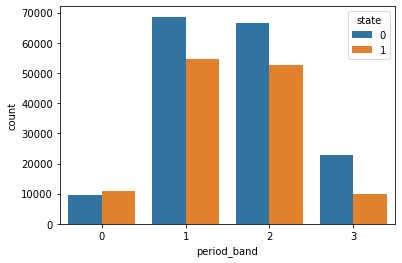

In [102]:
sns.countplot(df_kickstarter["period_band"], hue=df_kickstarter["state"])

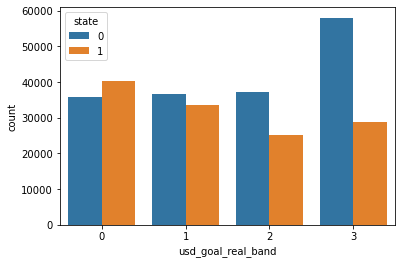

In [103]:
sns.countplot(df_kickstarter["usd_goal_real_band"], hue=df_kickstarter["state"])

# LASSOによる特徴選択

In [111]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

estimator = LassoCV(normalize=True, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-5)

### 標準化していないperiod, usd_goal_realの重要性を調べる.

In [121]:
y = df_kickstarter["state"].values
X = df_kickstarter.drop(["state", "period_band", "usd_goal_real_band"], axis=1).values

sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(cv=10, normalize=True), threshold=1e-05)

In [122]:
sfm.get_support()

array([False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [123]:
removed_idx = ~sfm.get_support()
df_kickstarter.drop(["state", "period_band", "usd_goal_real_band"], axis=1).columns[removed_idx]

Index(['usd_goal_real', 'Art'], dtype='object')

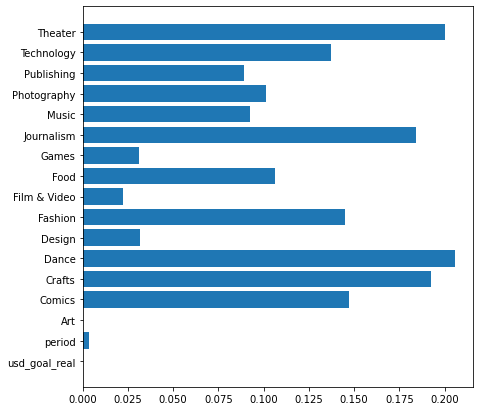

In [124]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)

# 係数を棒グラフで表示
plt.figure(figsize=(7, 7))
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_kickstarter.drop(["state", "period_band", "usd_goal_real_band"], axis=1).columns.values)
plt.show()

- 標準化していないとusd_goal_realとperiodはあまり重要ではない説明変数とされている．

### period_bandとusd_goal_real_bandの重要性を調べる．

In [125]:
y = df_kickstarter["state"].values
X = df_kickstarter.drop(["state", "period", "usd_goal_real"], axis=1).values

sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(cv=10, normalize=True), threshold=1e-05)

In [126]:
sfm.get_support()

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [127]:
removed_idx = ~sfm.get_support()
df_kickstarter.drop(["state", "period", "usd_goal_real"], axis=1).columns[removed_idx]

Index(['Art'], dtype='object')

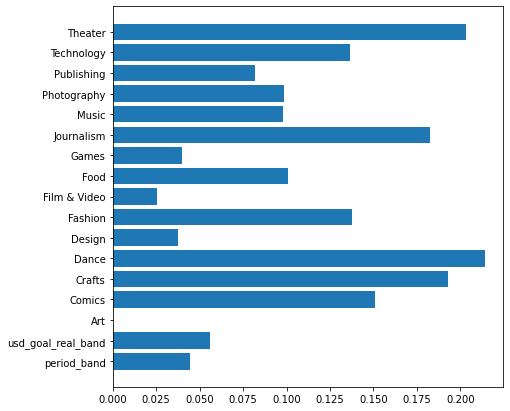

In [136]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)

# 係数を棒グラフで表示
plt.figure(figsize=(7, 7))
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_kickstarter.drop(["state", "period", "usd_goal_real"], axis=1).columns.values)
plt.show()

In [135]:
df_kickstarter.iloc[:, 5:].sum()

Art             24426
Comics           9575
Crafts           7510
Dance            3475
Design          21115
Fashion         18326
Film & Video    48735
Food            18400
Games           24634
Journalism       3709
Music           44376
Photography      9315
Publishing      33844
Technology      18551
Theater          9712
dtype: int64

- Artが不要だと判断されたが，Artはmain_categoryのなかで24426回登場するので直感にやや反する．

## Day1で考えたロジスティック回帰のモデルに最適な正則化項をつけていく．

In [138]:
y = df_kickstarter["state"].values
# bandなしの場合
X = df_kickstarter.drop(["state", "period_band", "usd_goal_real_band"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# GridSearchCVを用いて適切なペナルティを決める
parameters = {"penalty": ["none", "l1", "l2", "ElasticNet"]}
model = SGDClassifier(loss="log", max_iter=100000,
                   fit_intercept=True, random_state=1234, tol=1e-3)
clf = GridSearchCV(model, parameters, cv=5, verbose=True)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.7min finished


{'penalty': 'l2'} 0.5534228567831028


In [139]:
clf2 = SGDClassifier(**clf.best_params_, loss="log", max_iter=100000,
                   fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_test, y_test)
print("識別精度 = {:.3f}".format(clf2.score(X_test, y_test)))


識別精度 = 0.432


In [140]:
y_est = clf2.predict(X_test)
y_est_proba = clf2.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -1740418.128
正答率 = 43.196%


In [141]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

,予測値 = failed,予測値 = successful
正解 = failed,5,50384
正解 = successful,7,38315


In [142]:
# precision, recall, f1を計算
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 43.197%
再現率（Recall） = 99.982%
F1値（F1-score） = 60.329%


In [143]:
clf.cv_results_

{'mean_fit_time': array([13.44549503, 11.80884814, 14.44026337, 17.03374424]),
 'std_fit_time': array([1.99967667, 1.89248334, 2.32482964, 0.91945093]),
 'mean_score_time': array([0.00389781, 0.00368199, 0.00365782, 0.00385113]),
 'std_score_time': array([0.0005039 , 0.00035166, 0.00051948, 0.00027593]),
 'param_penalty': masked_array(data=['none', 'l1', 'l2', 'ElasticNet'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'penalty': 'none'},
  {'penalty': 'l1'},
  {'penalty': 'l2'},
  {'penalty': 'ElasticNet'}],
 'split0_test_score': array([0.61733375, 0.4973067 , 0.44298171, 0.58774367]),
 'split1_test_score': array([0.43353704, 0.46580835, 0.55989275, 0.47428682]),
 'split2_test_score': array([0.59326538, 0.57814387, 0.58886903, 0.5853906 ]),
 'split3_test_score': array([0.43634958, 0.47514373, 0.58524566, 0.52918015]),
 'split4_test_score': array([0.59681627, 0.472704  , 0.59012513, 0.58841007]),
 'mean_test_score': a

- penaltyが l2 > ElasticNet > none > l1の順で正答率がよかったが，ほとんどをsuccessfulと予測しており，標準化していないとusd_goal_real, periodは使い物にならないことがわかった．

## periodとusd_goal_realを標準化してロジスティック回帰を行う

In [155]:
df_kickstarter = pd.read_csv("ks-projects-201801_day1.csv")

df_kickstarter = df_kickstarter.drop(['Unnamed: 0', "usd_goal_real_band", "period_band"], axis=1)
df_kickstarter.columns

Index(['state', 'usd_goal_real', 'period', 'Art', 'Comics', 'Crafts', 'Dance',
       'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism',
       'Music', 'Photography', 'Publishing', 'Technology', 'Theater'],
      dtype='object')

In [156]:
y = df_kickstarter["state"].values
X = df_kickstarter.drop("state", axis=1).values

# df_kickstarterのusd_goal_real, periodを標準化していく
stdsc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train[:, 0] = stdsc.fit_transform(X_train[:, 0].reshape(-1, 1)).reshape(1, -1) # usd_goal_realの標準化
X_test[:, 0] = stdsc.transform(X_test[:, 0].reshape(-1, 1)).reshape(1, -1) 

X_train[:, 1] = stdsc.fit_transform(X_train[:, 1].reshape(-1, 1)).reshape(1, -1)  # periodの標準化
X_test[:, 1] = stdsc.transform(X_test[:, 1].reshape(-1, 1)).reshape(1, -1) 

# GridSearchCVを用いて適切なペナルティを決める
parameters = {"penalty": ["none", "l1", "l2", "ElasticNet"]}
model = SGDClassifier(loss="log", max_iter=100000,
                   fit_intercept=True, random_state=1234, tol=1e-3)
clf = GridSearchCV(model, parameters, cv=5, verbose=True)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.9s finished


{'penalty': 'l1'} 0.6219274123904666


In [157]:
clf2 = SGDClassifier(**clf.best_params_, loss="log", max_iter=100000,
                   fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_test, y_test)
print("識別精度 = ", clf2.score(X_test, y_test))


識別精度 =  0.6207572905276685


In [158]:
y_est = clf2.predict(X_test)
y_est_proba = clf2.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -57759.271
正答率 = 62.076%


In [159]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

,予測値 = failed,予測値 = successful
正解 = failed,40527,9833
正解 = successful,23810,14541


In [160]:
# precision, recall, f1を計算

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 59.658%
再現率（Recall） = 37.916%
F1値（F1-score） = 46.364%


In [168]:
clf.cv_results_

{'mean_fit_time': array([0.46550455, 0.55699291, 0.48219533, 0.56801763]),
 'std_fit_time': array([0.01985277, 0.01413961, 0.01297088, 0.02020137]),
 'mean_score_time': array([0.00511208, 0.00420232, 0.00464597, 0.00422211]),
 'std_score_time': array([0.00130263, 0.00061936, 0.00086054, 0.00040928]),
 'param_penalty': masked_array(data=['none', 'l1', 'l2', 'ElasticNet'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'penalty': 'none'},
  {'penalty': 'l1'},
  {'penalty': 'l2'},
  {'penalty': 'ElasticNet'}],
 'split0_test_score': array([0.61076355, 0.61076355, 0.61076355, 0.61139158]),
 'split1_test_score': array([0.61887968, 0.61887968, 0.61887968, 0.61887968]),
 'split2_test_score': array([0.62034398, 0.62089956, 0.62034398, 0.62089956]),
 'split3_test_score': array([0.62283202, 0.62346007, 0.62283202, 0.62292864]),
 'split4_test_score': array([0.62152761, 0.62271124, 0.62162423, 0.62256631]),
 'mean_test_score': array

-  l1 > ElasticNet > l2 > noneの順に良い結果が得られたがほとんどスコアは変わらなかった．

### bandを使って，正則化項付きのロジスティック回帰をする．

In [162]:
df_kickstarter = pd.read_csv("ks-projects-201801_day1.csv").drop('Unnamed: 0', axis=1)

In [163]:
y = df_kickstarter["state"].values
# bandありの場合
X = df_kickstarter.drop(["state", "period", "usd_goal_real"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# GridSearchCVを用いて適切なペナルティを決める
parameters = {"penalty": ["none", "l1", "l2", "ElasticNet"]}
model = SGDClassifier(loss="log", max_iter=100000,
                   fit_intercept=True, random_state=1234, tol=1e-3)
clf = GridSearchCV(model, parameters, cv=5, verbose=True)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.5s finished


{'penalty': 'l1'} 0.6193428202172659


In [164]:
clf2 = SGDClassifier(**clf.best_params_, loss="log", max_iter=100000,
                   fit_intercept=True, random_state=1234, tol=1e-3)
clf2.fit(X_test, y_test)
print("識別精度 = ", clf2.score(X_test, y_test))


識別精度 =  0.6158199095940752


In [165]:
y_est = clf2.predict(X_test)
y_est_proba = clf2.predict_proba(X_test)
print("対数尤度 = {:.3f}".format(-log_loss(y_test, y_est_proba, normalize=False)))
print("正答率 = {:.3f}%".format(100 * accuracy_score(y_test, y_est)))

対数尤度 = -57944.223
正答率 = 61.582%


In [166]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), index=["正解 = failed", "正解 = successful"], columns=["予測値 = failed", "予測値 = successful"])
display(conf_mat)

,予測値 = failed,予測値 = successful
正解 = failed,35546,14764
正解 = successful,19317,19084


In [167]:
# precision, recall, f1を計算

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

適合率（Precision） = 56.381%
再現率（Recall） = 49.697%
F1値（F1-score） = 52.828%


In [172]:
clf.cv_results_["rank_test_score"]

array([4, 1, 3, 2], dtype=int32)

# まとめ
## 標準化なしperiod, usd_goal_real + ロジスティック回帰(L2正則化)
- 正答率 = 43.196%
- 適合率（Precision） = 43.197%
- 再現率（Recall） = 99.982%
- F1値（F1-score） = 60.329%
- ほとんどの検証データに対してsuccessfulと予測してしまっている．

## 標準化ありperiod, usd_goal_real + ロジスティック回帰(L1正則化)
- 正答率 = 62.076%
- 適合率（Precision） = 59.658%
- 再現率（Recall） = 37.916%
- F1値（F1-score） = 46.364%
- 標準化を行うことで正答率が大幅に上昇した．

## period_band, usd_goal_real_band + ロジスティック回帰(L1正則化)
- 正答率 = 61.582%
- 適合率（Precision） = 56.381%
- 再現率（Recall） = 49.697%
- F1値（F1-score） = 52.828%
- 標準化と同等の正答率が得られ，precision, recall, f1-scoreのバランスが良くなった．

標準化を行うだけで，bandで束にした結果と同等の正答率が得られることがわかった．